In [1]:
import pandas as pd
import os
import json
import numpy as np

def get_label_from_json(trial_name, question_number, label_folder_path):
    """
    Get label from corresponding JSON file if label_folder_path is provided
    """
    if not label_folder_path:  # If no path provided
        return None
        
    json_path = os.path.join(
        label_folder_path,
        f"{trial_name}.json"
    )
    
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
            label = data[f"Q{question_number}"]["eval_databases"]
            # Explicitly handle "N/A" to prevent pandas from converting it
            if label == "N/A":
                return "N/A"  # Forces pandas to keep it as string
            return label
    except Exception as e:
        print(f"Error reading JSON for {trial_name}: {e}")
        return None

def process_csv_and_add_labels(label_folder_1_path, label_folder_2_path, output_path):
    """
    Read files from both folders and create a CSV with labels comparison
    """
    try:
        # Get list of JSON files from folder 1
        json_files = [f for f in os.listdir(label_folder_1_path) if f.endswith('.json')]
        print(f"Found {len(json_files)} JSON files")

        # Create empty lists to store data
        data_rows = []
        
        # Process each file
        for json_file in json_files:
            trial_name = json_file.replace('.json', '')
            
            # Process each question (Q1-Q15)
            for question_num in range(1, 16):
                # Get labels from both folders
                label_1 = get_label_from_json(trial_name, question_num, label_folder_1_path)
                label_2 = get_label_from_json(trial_name, question_num, label_folder_2_path)
                
                # Add row to data
                data_rows.append({
                    'NCT_file': trial_name,
                    'Q': question_num,
                    'factual': label_1,
                    'counterfactual': label_2
                })
        
        # Create DataFrame
        df = pd.DataFrame(data_rows)
        
        # Create Final_label column based on combinations
        print("Creating Final_label column...")
        conditions = [
            (df['factual'] == 'fact') & (df['counterfactual'] == 'fact'),
            (df['factual'] == 'hallucination') & (df['counterfactual'] == 'hallucination'),
            (df['factual'] == 'fact') & (df['counterfactual'] == 'hallucination'),
            (df['factual'] == 'hallucination') & (df['counterfactual'] == 'fact')
        ]
        
        choices = ['fact', 'hallucination', 'error', 'coverage']
        
        df['Final_label'] = np.select(conditions, choices, default='N/A')
        
        # Save the DataFrame
        print(f"Saving CSV to: {output_path}")
        df.to_csv(output_path, index=False)
        
        # Print summary
        print("\nProcessing complete!")
        print(f"Total rows processed: {len(df)}")
        print("\nFactual distribution:")
        print(df['factual'].value_counts(dropna=False))
        print("\nCounterfactual distribution:")
        print(df['counterfactual'].value_counts(dropna=False))
        print("\nFinal_label distribution:")
        print(df['Final_label'].value_counts(dropna=False))
        print("\nDetailed combination counts:")
        print(pd.crosstab(df['factual'], df['counterfactual'], margins=True))
        
    except Exception as e:
        print(f"Error processing files: {e}")
        return None

# Example usage
if __name__ == "__main__":
    # Define paths
    label_folder_1_path = "Database_dependent_evaluation/Clinical_trials/5-Labels/Inference_files_with_labels/GptO3/Paragraph_level/Inference_title_Paragraph"
    label_folder_2_path = "Database_dependent_evaluation/Clinical_trials/5-Labels/Inference_files_with_labels_Counterfactual/GptO3/Paragraph_level/Inference_title_Paragraph"
    output_path = "Paragraph_Gpt5_title.csv"
    output_path = "Paragraph_Gpto3_title.csv"
    
    # Process the files and add labels
    process_csv_and_add_labels(label_folder_1_path, label_folder_2_path, output_path)

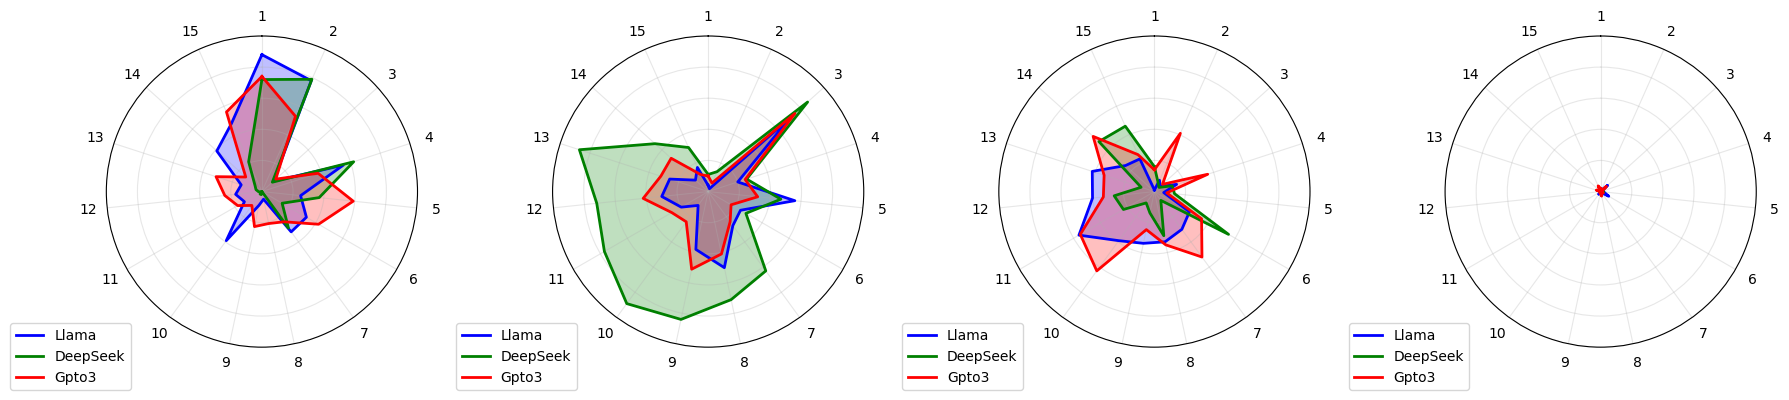

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_normalized_label_comparison_radar(csv_paths):
    """
    Create four radar plots showing the distribution patterns
    """
    dfs = {
        'Llama': pd.read_csv(csv_paths['summary']),
        'DeepSeek': pd.read_csv(csv_paths['title']),
        'Gpto3': pd.read_csv(csv_paths['json'])
    }
    
    fig, axes = plt.subplots(1, 4, figsize=(18, 6), subplot_kw=dict(projection='polar'))
    # fig.suptitle('Label Distribution Rate by Input Type', fontsize=16, y=0.95)
    
    labels = ['fact', 'hallucination', 'coverage', 'error']
    colors = {'Llama': 'blue', 'DeepSeek': 'green', 'Gpto3': 'red'}
    q_order = [i for i in range(1, 16)]
    q_labels = [i for i in range(1, 16)]
    angles = np.linspace(0, 2*np.pi, len(q_order), endpoint=False)
    
    for idx, label in enumerate(labels):
        row = idx // 2
        col = idx % 2
        ax = axes[idx]
        
        for input_type, df in dfs.items():
            rates = []
            for q in q_order:
                q_total = len(df[df['Q'] == q])
                if q_total > 0:
                    q_label_count = len(df[(df['Q'] == q) & (df['Final_label'] == label)])
                    rates.append(q_label_count / q_total)
                else:
                    rates.append(0)
            
            # Close the plot by appending first value
            rates.append(rates[0])
            angles_plot = np.concatenate((angles, [angles[0]]))
            
            ax.plot(angles_plot, rates, color=colors[input_type], label=input_type, linewidth=2)
            ax.fill(angles_plot, rates, color=colors[input_type], alpha=0.25)
        
        # ax.set_title(f'{label.capitalize()}')
        ax.set_xticks(angles)
        ax.set_xticklabels(q_labels)
        ax.set_ylim(0, 1)
        

        # Set direction to clockwise and rotate to start at top
        ax.set_theta_direction(-1)
        ax.set_theta_zero_location('N')

        ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
        
        # Remove radial labels
        ax.set_yticklabels([])

        # Add gridlines but make them lighter
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('input_type_comparison_radar.png', dpi=600, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    csv_paths = {
        'summary': "Paragraph_Llama_title.csv",
        'title': "Paragraph_DeepSeek_title.csv",
        'json': "Paragraph_Gpto3_title.csv"
    }
    
    plot_normalized_label_comparison_radar(csv_paths)